In [97]:
import copy
import math
import os
import random
import warnings
from collections import defaultdict
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import paddle
from paddle import nn
from paddle.io import DataLoader, Dataset
from sklearn.metrics import log_loss, roc_auc_score

InteractiveShell.ast_node_interactivity = 'all'

In [98]:
# 参数配置
config = {
    'data_path': '../../data/data.csv',
    "debug_mode" : True,
    "epoch" : 10,
    "batch" : 20480, #2,  # 
    "lr" : 0.001,
}

In [99]:
# 训练集太大了，一共有900w条数据，这里用valid数据来完成流程
df = pd.read_csv(config['data_path'])
df.head()  # 查看数据 原始数据为三列，用户ID，电影ID,时间戳

,user_id,item_id,timestamp
0,110120,318,851527751
1,110120,162,851526935
2,110120,164,851527569
3,110120,312,851526935
4,110120,403,851527514


In [100]:
# 给原始数据增加一列，用来统计每个用户的观看记录次数
df['user_count'] = df['user_id'].map(df['user_id'].value_counts())  
df.head()
df.shape[0]

,user_id,item_id,timestamp,user_count
0,110120,318,851527751,50
1,110120,162,851526935,50
2,110120,164,851527569,50
3,110120,312,851526935,50
4,110120,403,851527514,50


1213373

In [101]:
# 剔除掉用户观看记录少于20条的用户数据,重新排序
df = df[df['user_count']>20].reset_index(drop=True)
df.head()
df.shape[0]

,user_id,item_id,timestamp,user_count
0,110120,318,851527751,50
1,110120,162,851526935,50
2,110120,164,851527569,50
3,110120,312,851526935,50
4,110120,403,851527514,50


1165680

In [102]:
# 将数据根据用户分组，然后取出电影ID列，运用apply函数，把同一个用户看过的电影Id变成一个list，然后在把用户和用户看过的电影记录转换成字典
pos_dict = df.groupby('user_id')['item_id'].apply(list).to_dict()
pos_dict.get(110120)  # 用户ID：110120的用户的电影观看记录

[318,
 162,
 164,
 312,
 403,
 9,
 1164,
 198,
 12,
 295,
 320,
 297,
 298,
 937,
 299,
 416,
 321,
 301,
 200,
 1391,
 166,
 2140,
 421,
 718,
 728,
 422,
 324,
 425,
 16,
 325,
 305,
 427,
 3245,
 1383,
 432,
 328,
 1130,
 439,
 1386,
 21,
 744,
 22,
 23,
 26,
 27,
 29,
 30,
 168,
 47,
 961]

In [103]:
# sourcery skip: for-index-underscore
'''
这里的样本构造逻辑是来自于《Neural Collaborative Filtering》的实验部分的样本构造逻辑
'''
# 负采样：负采样就是从收集到的数据中为每个用户采样一些他没有看过的电影，最好是他不喜欢且没有看过的，当然在他没有看过的电影中也有他喜欢的，这种被称为伪负样本
ratio = 3  # ratio 表示负样本的数量为正样本数量的3倍

# 构造样本，这
train_user_list = []
train_item_list = []
train_label_list = []

test_user_list = []
test_item_list = []
test_label_list = []

# 获取用户列表
if config['debug_mode']:
    user_list = df['user_id'].unique()[:100]  # 调试模型的时候只选用100个用户的数据
else:
    user_list = df['user_id'].unique()
item_list = df['item_id'].unique()  # 统计所有的电影构成一个list
item_num = df['item_id'].nunique()  # 统计电影的数量

# 遍历用户列表，生成三个一一对应的list，分别是用户ID，电影ID，标签。他们是按照顺序一一对应的，用来构建训练数据
# 举例说明：比如有一个用户的数据为：{user1:[Item1, Item5]},表示这个用户看过两个电影，Item1和Item5
# 最终得到的数据的样子变为了train_user_list=[user1, user1],train_item_list=[Item1, Item5],train_label_list=[1, 1]
# train_user_list，train_item_list，train_label_list为三个长度相等且对应的列表
for user in tqdm(user_list):
    # 训练集正样本，所谓训练集正样本就是用户的观看记录，表示用户看过的电影，最好是看过的且评分了的，还是喜欢的
    # 遍历每个用户的观看记录
    for i in range(len(pos_dict[user])-1):
        train_user_list.append(user)  # 用户编号
        train_item_list.append(pos_dict[user][i])  # 电影编号
        train_label_list.append(1)  # 用户编号-电影编号-标签
    
    # 测试集正样本
    test_user_list.append(user)
    test_item_list.append(pos_dict[user][-1])  # 也就是说对于每个用户我们只取该用户观看记录的最后一个作为测试
    test_label_list.append(1)

    # 训练集负样本数计算：每个用户的负样本数
    user_count = len(pos_dict[user])-1  # 用户实际观看过的电影的数量
    # 也就是说负样本的数量是正样本的三倍
    # 意思就是在训练数据集中对一个用户来说，用户没有看过的电影的数量是用户看过的电影的数量的三倍
    # 来构成一个用户的训练数据集
    neg_sample_per_user = user_count * ratio 

    # 训练集负采样
    for i in range(neg_sample_per_user):
        train_user_list.append(user)
        temp_item_index = random.randint(0, item_num-1)
        # 为了防止 负采样选出来的Item 在用户的正向历史行为序列(pos_dict)当中,所以需要排除用户已经看过的电影
        # 意思就是只要采样的电影为用户已经看过的，就重新采样，只到是用户没有看过的电影
        while item_list[temp_item_index] in pos_dict[user]:
            temp_item_index = random.randint(0, item_num-1)
        train_item_list.append(item_list[temp_item_index])
        train_label_list.append(0)
    
    # 测试集负采样，与训练集的逻辑一样，只是每个用户负样本数为 100(论文设定)
    for i in range(100):
        test_user_list.append(user)
        temp_item_index = random.randint(0, item_num - 1)
        while item_list[temp_item_index] in pos_dict[user]:
            temp_item_index = random.randint(0, item_num - 1)
        test_item_list.append(item_list[temp_item_index])
        test_label_list.append(0)

# 合成训练数据集,userID, itemID, label 
train_df = pd.DataFrame()
train_df['user_id'] = train_user_list
train_df['item_id'] = train_item_list
train_df['label'] = train_label_list

# 合成测试集数据
test_df = pd.DataFrame()
test_df['user_id'] = test_user_list
test_df['item_id'] = test_item_list
test_df['label'] = test_label_list

# 查看训练集和测试集数据
train_df.head()
test_df.head()

# 查看训练集和测试集数据的大小
train_df.shape
test_df.shape

'\n这里的样本构造逻辑是来自于《Neural Collaborative Filtering》的实验部分的样本构造逻辑\n'

100%|██████████| 100/100 [00:01<00:00, 84.10it/s]


,user_id,item_id,label
0,110120,318,1
1,110120,162,1
2,110120,164,1
3,110120,312,1
4,110120,403,1


,user_id,item_id,label
0,110120,961,1
1,110120,14113,0
2,110120,4999,0
3,110120,4783,0
4,110120,13641,0


(50164, 3)

(10100, 3)

In [104]:
# 通过查看用户ID和电影的ID可以发现其实无论是用户ID还是电影ID排序之后他们都是顺序增加的
# 即ID是顺序增加的这个特性还是非常重要的，因为在Embedding中需要保证输入的值不能大于第一个参数的值
train_df.item_id.sort_values().unique()
train_df.user_id.sort_values().unique()

array([    0,     1,     2, ..., 15402, 15403, 15404], dtype=int64)

array([110120, 110121, 110123, 110124, 110125, 110126, 110128, 110132,
       110133, 110134, 110135, 110136, 110137, 110138, 110139, 110140,
       110142, 110143, 110144, 110145, 110146, 110147, 110148, 110149,
       110152, 110153, 110154, 110155, 110156, 110157, 110158, 110159,
       110160, 110161, 110162, 110163, 110165, 110166, 110168, 110169,
       110170, 110171, 110173, 110175, 110176, 110177, 110178, 110179,
       110180, 110181, 110182, 110185, 110186, 110187, 110189, 110190,
       110191, 110192, 110195, 110196, 110198, 110199, 110201, 110202,
       110203, 110204, 110205, 110207, 110208, 110209, 110210, 110211,
       110212, 110213, 110214, 110217, 110218, 110219, 110220, 110222,
       110223, 110224, 110225, 110226, 110228, 110229, 110230, 110231,
       110232, 110233, 110235, 110237, 110239, 110241, 110242, 110243,
       110244, 110245, 110246, 110247], dtype=int64)

In [105]:
# vocab_map 用来存放特征索引和每个特征的最大值的字典
vocab_map = {
    'user_id':df['user_id'].max()+1,  # Embadding的第一个参数的值需要大于该维度特征的上界
    'item_id':df['item_id'].max()+1
}

In [106]:
train_df.user_id.shape
paddle.to_tensor(np.array(train_df.user_id)).shape

(50164,)

[50164]

In [107]:
# 构造Dataset
class BaseDataset(Dataset):
    # Dataset 必须要实现两个方法，第一个就是__getitem__，另一个是__len__
    def __init__(self, df:pd.DataFrame):
        self.df = df
        self.feature_name = df.columns[:2]
        # 数据编码，也就是把原来的DF数据转换为字典类型，里面的值变为tensor
        self.__enc_data()
    
    def __enc_data(self):
        # 数据编码,将用户ID和电影ID两列数据取出来转换为tensor,然后存在字典里
        self.enc_data = defaultdict(dict)
        for col in self.feature_name:
            self.enc_data[col] = paddle.to_tensor(np.array(self.df[col])).squeeze(-1)
    
    def __getitem__(self, idx):  # sourcery skip: move-assign
        """
        _summary_
        
        Args:
            idx (int): 每个特征的第idx个值，比如用户字典的第几个用户
        
        Returns:
            dict: 每个特征对应的记录组成的自动，
            {userID:userID, 
             itemID:itemID,
             label:0/1}
        """
        # 根据给定索引获取数据集中指定样本，
        # 在 paddle.io.DataLoader 中需要使用此函数通过下标获取样本。
        data = {col: self.enc_data[col][idx] for col in self.feature_name}
        if 'label' in self.df.columns:
            data['label'] = paddle.to_tensor(self.df['label'].iloc[idx], dtype='float32').squeeze(-1)
        return data
    
    def __len__(self):
        # 返回数据集样本个数，paddle.io.BatchSampler 中需要样本个数生成下标序列。
        return len(self.df)

In [108]:
train_dataset = BaseDataset(train_df)
test_dataset = BaseDataset(test_df)
train_dataset.feature_name
train_dataset.enc_data
train_dataset.__getitem__(777)
test_dataset.__getitem__(777)

Index(['user_id', 'item_id'], dtype='object')

defaultdict(dict,
            {'user_id': Tensor(shape=[50164], dtype=int64, place=Place(cpu), stop_gradient=True,
                    [110120, 110120, 110120, ..., 110247, 110247, 110247]),
             'item_id': Tensor(shape=[50164], dtype=int64, place=Place(cpu), stop_gradient=True,
                    [318  , 162  , 164  , ..., 14363, 12058, 8692 ])})

{'user_id': Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
        [110123]),
 'item_id': Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
        [1987]),
 'label': Tensor(shape=[], dtype=float32, place=Place(cpu), stop_gradient=True,
        0.)}

{'user_id': Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
        [110132]),
 'item_id': Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
        [5069]),
 'label': Tensor(shape=[], dtype=float32, place=Place(cpu), stop_gradient=True,
        0.)}

In [109]:
#dataloader
train_loader = DataLoader(train_dataset, batch_size=config['batch'], shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config['batch'], shuffle=False, num_workers=0)

# 测试数据加载器
pbar = tqdm(train_loader)
for data in pbar:
    print(data)
    user_emb_layer = nn.Embedding(vocab_map['user_id'], 10)
    user_emb = user_emb_layer(data['user_id']).squeeze(1)
    user_emb.shape
    user_emb
    break

  0%|          | 0/3 [00:00<?, ?it/s]

{'user_id': Tensor(shape=[20480, 1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [[110211],
        [110229],
        [110245],
        ...,
        [110177],
        [110177],
        [110142]]), 'item_id': Tensor(shape=[20480, 1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [[4684 ],
        [2215 ],
        [12764],
        ...,
        [1058 ],
        [4415 ],
        [1605 ]]), 'label': Tensor(shape=[20480], dtype=float32, place=Place(cpu), stop_gradient=True,
       [0., 0., 0., ..., 1., 0., 0.])}


[20480, 10]

Tensor(shape=[20480, 10], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[ 0.00092908,  0.00552352,  0.00400929, ...,  0.00482160,
          0.00422718,  0.00221831],
        [ 0.00452675,  0.00269489, -0.00662085, ..., -0.00484101,
          0.00274427,  0.00461381],
        [-0.00591011,  0.00339684,  0.00254230, ...,  0.00384749,
         -0.00304255, -0.00514060],
        ...,
        [ 0.00628231, -0.00155299,  0.00668301, ..., -0.00360251,
         -0.00626766,  0.00393799],
        [ 0.00628231, -0.00155299,  0.00668301, ..., -0.00360251,
         -0.00626766,  0.00393799],
        [ 0.00501211, -0.00597799, -0.00391858, ..., -0.00581707,
          0.00347522, -0.00393622]])

  0%|          | 0/3 [00:03<?, ?it/s]


In [110]:
# 定义NCF模型
class NCF(nn.Layer):
    def __init__(self, embedding_dim=16, vocab_map = None, loss_fun = 'nn.BCELoss()'):
        super().__init__()
        self.embadding_dim = embedding_dim  # 用来决定把用户ID和电影ID"降维"到多少维度，也就是把用户ID或者电影ID变为多少维的向量表示
        self.vocab_map = vocab_map  # 存放了用户ID和电影ID，并且他们对应的最大值+1
        self.loss_fun = eval(loss_fun)  # 损失函数

        # 定义embadding层
        # userID to Embadding, 把用户ID变为维度为embadding_dim大的向量
        self.user_emb_layer = nn.Embedding(self.vocab_map['user_id'], self.embadding_dim)
        # itemID to Embadding, 把电影ID变为维度为embadding_dim大的向量
        self.item_emb_layer = nn.Embedding(self.vocab_map['item_id'], self.embadding_dim)

        # 定义全连接网络MLP
        self.mlp = nn.Sequential(
            nn.Linear(2*self.embadding_dim, self.embadding_dim),  # 拼接好的用户和电影的Embadding向量输入到第一个线性层
            nn.ReLU(),  # 非线性变换
            nn.BatchNorm1D(self.embadding_dim),  # 对第一层输出进行归一化
            nn.Linear(self.embadding_dim, 1),  # 第一次归一化的输出值输入第二个线性层
            nn.Sigmoid()  # 通过Sigmoid函数进行二分类，判断是不是需要被召回
        )

    def forward(self, data):
        # sourcery skip: lift-return-into-if, remove-unreachable-code
        user_emb = self.user_emb_layer(data['user_id'])  # 获取用户ID的Embadding向量
        item_emb = self.item_emb_layer(data['item_id'])  # 获取电影ID的Embadding向量
        mlp_input = paddle.concat([user_emb, item_emb], axis=-1).squeeze(1)  # 拼接两个Embadding向量
        y_pred = self.mlp(mlp_input)  # 送入MLP
        if 'label' in data.keys():
            loss = self.loss_fun(y_pred.squeeze(), data['label'])
            output_dict = {'pred':y_pred, 'loss':loss}
        else:
            output_dict = {'pred':y_pred}
        return output_dict


In [111]:
#训练模型，验证模型
def train_model(model, train_loader, optimizer, metric_list=['roc_auc_score','log_loss']):
    model.train()
    pred_list = []
    label_list = []
    pbar = tqdm(train_loader)
    for data in pbar:

        output = model(data)
        pred = output['pred']
        loss = output['loss']

        loss.backward()
        optimizer.step()
        optimizer.clear_grad()

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())
        pbar.set_description("Loss {}".format(loss.numpy()[0]))

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def valid_model(model, valid_loader, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (valid_loader):

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def test_model(model, test_loader):
    model.eval()
    pred_list = []

    for data in tqdm(test_loader):

        output = model(data)
        pred = output['pred']
        pred_list.extend(pred.squeeze().cpu().detach().numpy())

    return np.array(pred_list)

In [112]:
# sourcery skip: for-index-underscore
model = NCF(embedding_dim=64,vocab_map=vocab_map)
optimizer = paddle.optimizer.Adam(parameters=model.parameters(), learning_rate=config['lr'])
train_metric_list = []
#模型训练流程
for i in range(config['epoch']):
    #模型训练
    train_metirc = train_model(model,train_loader,optimizer=optimizer)
    train_metric_list.append(train_metirc)

    print("Train Metric:")
    print(train_metirc)

  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.6446714401245117: 100%|██████████| 3/3 [00:14<00:00,  4.93s/it]


Train Metric:
{'roc_auc_score': 0.5986805316676285, 'log_loss': 0.7693352788208615}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.444562166929245: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it]  


Train Metric:
{'roc_auc_score': 0.9239580617379213, 'log_loss': 0.4763439563557064}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.3774862289428711: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it] 


Train Metric:
{'roc_auc_score': 0.9585084422019307, 'log_loss': 0.3899476381281451}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.3360055685043335: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it] 


Train Metric:
{'roc_auc_score': 0.9654052285517563, 'log_loss': 0.34884939603810405}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.3064713478088379: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


Train Metric:
{'roc_auc_score': 0.9697365699538552, 'log_loss': 0.31996905884624194}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.28858453035354614: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Train Metric:
{'roc_auc_score': 0.9736294653454275, 'log_loss': 0.2956646558852967}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.27399224042892456: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]


Train Metric:
{'roc_auc_score': 0.9771905654172174, 'log_loss': 0.27469117953201766}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.254406213760376: 100%|██████████| 3/3 [00:08<00:00,  2.94s/it]  


Train Metric:
{'roc_auc_score': 0.9803832934394134, 'log_loss': 0.2556558806328582}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.23798345029354095: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


Train Metric:
{'roc_auc_score': 0.9831873052221051, 'log_loss': 0.2379267375439285}


  0%|          | 0/3 [00:00<?, ?it/s]d:\conda\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:711: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
Loss 0.22399714589118958: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]

Train Metric:
{'roc_auc_score': 0.9857258623101283, 'log_loss': 0.22106968207196542}


In [113]:
# 计算指标
y_pre = test_model(model,test_loader)
test_df['y_pre'] = y_pre
test_df['ranking'] = test_df.groupby(['user_id'])['y_pre'].rank(method='first', ascending=False)
test_df = test_df.sort_values(by=['user_id','ranking'],ascending=True)
test_df

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


,user_id,item_id,label,y_pre,ranking
42,110120,4236,0,0.525636,1.0
0,110120,961,1,0.506582,2.0
59,110120,93,0,0.490695,3.0
73,110120,758,0,0.485031,4.0
6,110120,5422,0,0.461529,5.0
...,...,...,...,...,...
10093,110247,7669,0,0.392324,97.0
10055,110247,13822,0,0.391283,98.0
10022,110247,12838,0,0.390465,99.0
10049,110247,2612,0,0.390427,100.0


In [114]:
#  Hitrate
def hitrate(test_df,k=20):
    user_num = test_df['user_id'].nunique()
    test_gd_df = test_df[test_df['ranking']<=k].reset_index(drop=True)
    return test_gd_df['label'].sum() / user_num

hitrate(test_df,k=5)

0.34

In [115]:
# NDCG
def ndcg(test_df,k=20):
    '''
    idcg@k 一定为1
    dcg@k 1/log_2(ranking+1) -> log(2)/log(ranking+1)
    '''
    user_num = test_df['user_id'].nunique()
    test_gd_df = test_df[test_df['ranking']<=k].reset_index(drop=True)
    
    test_gd_df = test_gd_df[test_gd_df['label']==1].reset_index(drop=True)
    test_gd_df['ndcg'] = math.log(2) / np.log(test_gd_df['ranking']+1)
    return test_gd_df['ndcg'].sum() / user_num

ndcg(test_df,k=5)

0.20428380506821836

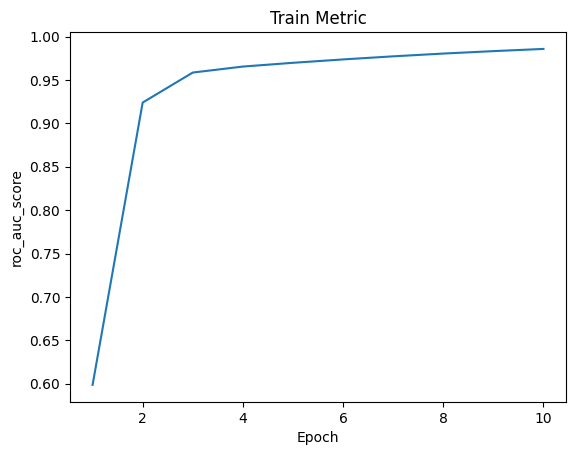

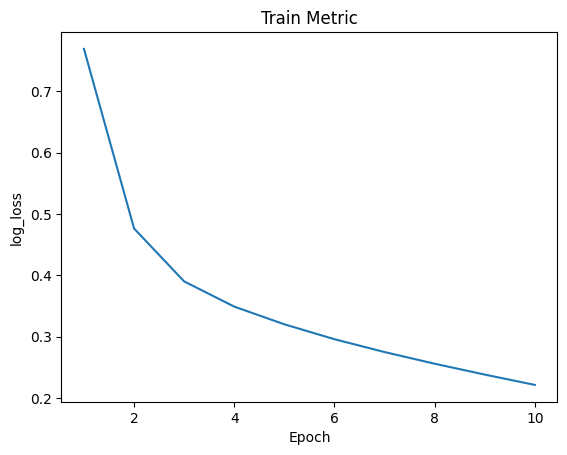

In [116]:
# 训练过程可视化
def plot_metric(metric_dict_list, metric_name):
    epoch_list = [x for x in range(1,1+len(metric_dict_list))]
    metric_list = [metric_dict_list[i][metric_name] for i in range(len(metric_dict_list))]
    plt.figure(dpi=100)
    plt.plot(epoch_list,metric_list)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title('Train Metric')
    plt.show()

plot_metric(train_metric_list,'roc_auc_score')   
plot_metric(train_metric_list,'log_loss')     